#  Importing the Dependencies

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
%matplotlib inline

from seaborn import heatmap
from sklearn.metrics import r2_score

# Data Collection

In [6]:
path = "/content/"

df1 = pd.read_csv(path+'stories_regions.csv')
df2 = pd.read_csv(path+'stories_societe.csv')
df3 = pd.read_csv(path+'stories_art-et-culture.csv')
df4 = pd.read_csv(path+'stories_faits-divers.csv')
df5 = pd.read_csv(path+'stories_marocains-du-monde.csv')
df6 = pd.read_csv(path+'stories_medias.csv')
# Concatenate the DataFrames vertically
df = pd.concat([df1, df2,df3 , df4,df5,df6], ignore_index=True)

In [7]:
df.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,2390721404e111eb8234646e69d991ea,جهة الدار البيضاء تحصي 1247 إصابة بالجائحة في ...,الجمعة 02 أكتوبر 2020 - 19:03,هسبريس من الرباط,بلغ مؤشر الإصابة بفيروس كورونا في آخر 24 ساعة ...,regions
1,1,252ae82804e111eba71c646e69d991ea,"إقليم سيدي إفني يسجل أول وفاة بسبب ""كورونا""",الجمعة 02 أكتوبر 2020 - 18:15,مصطفى البكار من تزنيت,سجل إقليم سيدي إفني، اليوم الجمعة، أول وفاة نا...,regions
2,2,2658ba0a04e111eb8e5f646e69d991ea,قبور إسمنتية معدة للدفن تثير رفضا بمدينة صفرو,الجمعة 02 أكتوبر 2020 - 16:10,رشيد الكويرتي من فاس,طالب ممثلو فرق المعارضة بمجلس جماعة صفرو، المن...,regions
3,3,2768a33a04e111eb9c88646e69d991ea,الفيروس يقتل نائب رئيس بلدية الفقيه بن صالح,الجمعة 02 أكتوبر 2020 - 15:05,حميد رزقي من الفقيه بن صالح,توفي النائب الأول لرئيس بلدية الفقيه بنصالح، ب...,regions
4,4,2882027604e111eb8b80646e69d991ea,"""شباب ملعب"" يطلق مبادرات اجتماعية وتنموية",الجمعة 02 أكتوبر 2020 - 10:27,محمد ايت حساين,نجح سكان مركز جماعة ملعب، الواقعة بالنفوذ الإد...,regions


# EDA

In [8]:
#understanding the dataset and it's shape

print('data has ',df.shape[0],'rows and ',df.shape[1],'columns')

data has  6000 rows and  7 columns


In [9]:
df.columns

Index(['Unnamed: 0', 'id', 'title', 'date', 'author', 'story', 'topic'], dtype='object')

<h>
drop some cloumns that no need for   <br>
there is no need for the date as i want by the tittle and the story to cllsify the topic and also no need to the author so
that will be unuseful
   <br>
    i didn't remove the id cause i will need it later
</h>

In [10]:
df.drop(columns = {"Unnamed: 0","date","author"},inplace = True)


In [11]:
#checking the dataType of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6000 non-null   object
 1   title   6000 non-null   object
 2   story   6000 non-null   object
 3   topic   6000 non-null   object
dtypes: object(4)
memory usage: 187.6+ KB


We Can Note that  all the colums are "Categorical" Which must be considered

In [12]:
#Checking for missing values
df.isnull().sum()

id       0
title    0
story    0
topic    0
dtype: int64

In [13]:
#number of examples per class
class_counts=df["topic"].value_counts()
class_counts

regions               1000
societe               1000
art-et-culture        1000
faits-divers          1000
marocains-du-monde    1000
medias                1000
Name: topic, dtype: int64

data is balanced

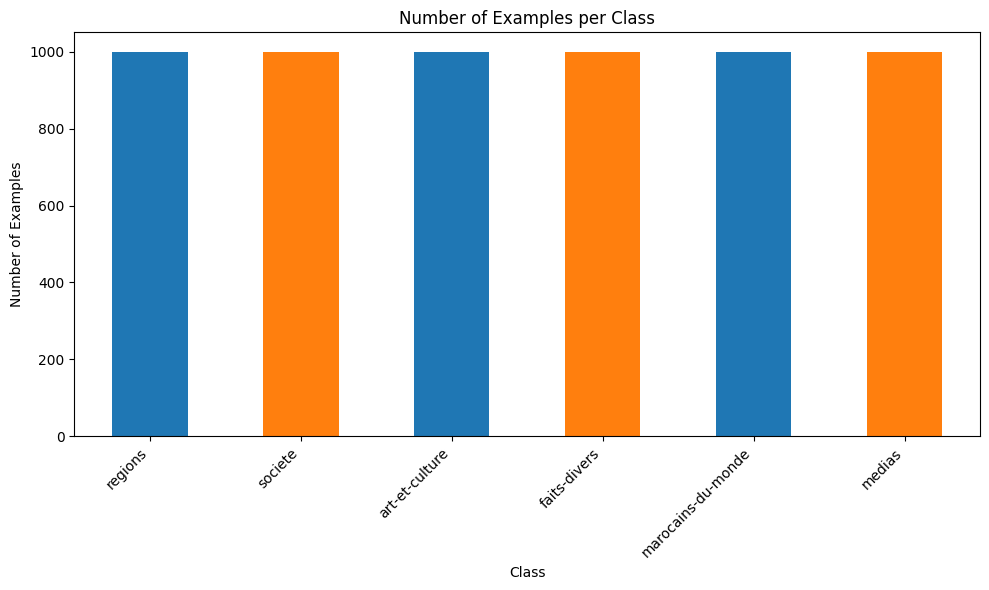

In [14]:
# Create a bar plot with custom colors
plt.figure(figsize=(10, 6))

# Set the colors using the 'color' parameter in 'plot()'
class_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e']
                                     )

plt.xlabel("Class")
plt.ylabel("Number of Examples")
plt.title("Number of Examples per Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
#Length of Examples
example_word_length =df['story'].apply(lambda x: len(x.split()))
example_letter_length = df['story'].apply(lambda x: len(x))

In [16]:
# Combine the lengths into a new DataFrame
length_df = pd.DataFrame({'Example_ID': df.id, 'Words_Length': example_word_length, 'Letters_Length': example_letter_length})

# Print the first few rows of the length DataFrame
length_df.head()

,Example_ID,Words_Length,Letters_Length
0,2390721404e111eb8234646e69d991ea,354,2086
1,252ae82804e111eba71c646e69d991ea,79,488
2,2658ba0a04e111eb8e5f646e69d991ea,261,1629
3,2768a33a04e111eb9c88646e69d991ea,152,946
4,2882027604e111eb8b80646e69d991ea,547,3382


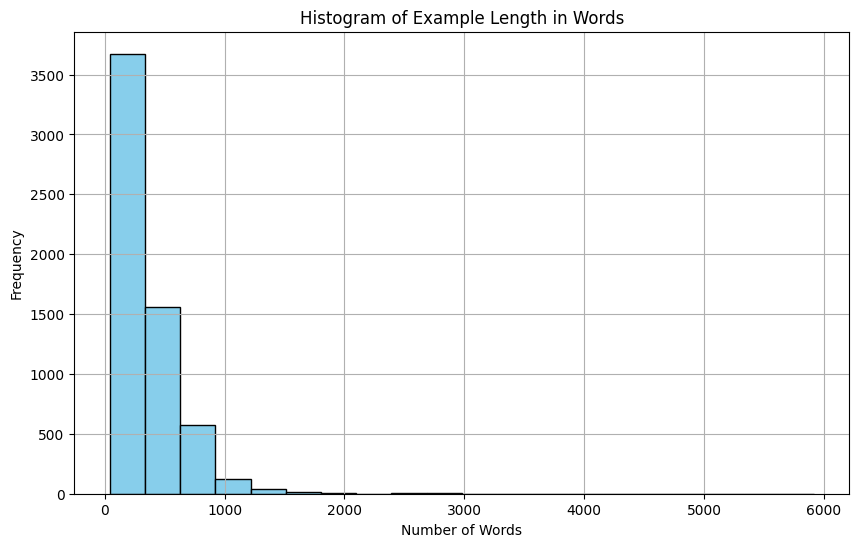

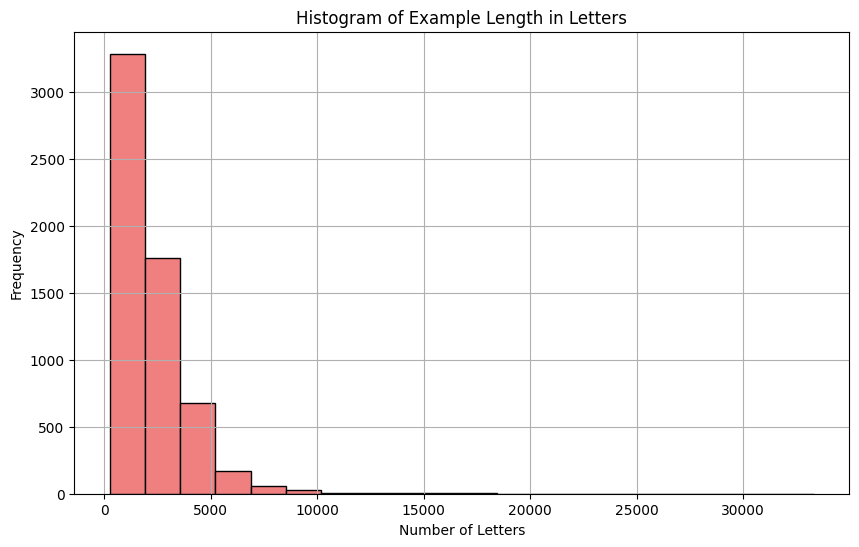

In [17]:
# Visualization - Histogram for the length of examples in words
plt.figure(figsize=(10, 6))
plt.hist(example_word_length, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Example Length in Words')
plt.grid(True)
plt.show()

# Visualization - Histogram for the length of examples in letters
plt.figure(figsize=(10, 6))
plt.hist(example_letter_length, bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Number of Letters')
plt.ylabel('Frequency')
plt.title('Histogram of Example Length in Letters')
plt.grid(True)
plt.show()


# Data Preprocessing
Before extracting n-grams, it's essential to preprocess the text data to make it suitable for analysis.

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# Print the list of Arabic stopwords
print(stopwords.words('arabic'))


['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير', 'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df.columns

Index(['id', 'title', 'story', 'topic'], dtype='object')

In [21]:
port_stem = PorterStemmer()

In [22]:
def stemming(content):
    stemmed_content = re.sub('[^ء-ي]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('arabic')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [23]:
df['title'] = df['title'].apply(stemming)
df['story'] = df['story'].apply(stemming)

In [24]:
ngram_range = (1, 1)
vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None)

# Fit and transform the preprocessed text data to get the n-gram frequencies
ngrams_matrix = vectorizer.fit_transform(df['story'])

# Create a DataFrame to store the n-gram frequencies
ngrams_df = pd.DataFrame(ngrams_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the sum of each n-gram frequency across all examples
general_ngram_frequencies = ngrams_df.sum().sort_values(ascending=False)


In [25]:
ngrams_df_with_class = pd.concat([df['topic'], ngrams_df], axis=1)
ngrams_per_class = ngrams_df_with_class.groupby('topic').sum()

In [26]:
ngrams_per_class

,ءا,آباء,آباءهم,آباؤهم,آباؤهن,آبائنا,آبائهم,آبائهن,آباد,آبار,...,ييرو,ييس,ييسر,ييسي,ييف,ييكسيانغ,ييمو,يين,يينا,ييوا
topic,,,,,,,,,,,,,,,,,,,,,
art-et-culture,1,1,0,1,0,2,0,0,0,0,...,1,1,0,0,1,1,1,2,2,1
faits-divers,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
marocains-du-monde,1,6,0,1,0,0,3,0,1,0,...,0,0,0,1,0,0,0,1,0,0
medias,0,16,1,0,0,0,1,1,0,4,...,0,0,1,0,0,0,0,0,0,0
regions,0,18,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,1,0,0
societe,0,69,2,1,1,0,5,0,0,1,...,0,0,0,0,0,0,0,2,0,0


In [27]:
for class_name in ngrams_per_class.index:
    top_ngrams = ngrams_per_class.loc[class_name].sort_values(ascending=False)[:20]

In [28]:
top_ngrams

حالة        1350
كورونا      1097
خلال        1086
الصحة       1000
وزارة        894
المغرب       873
الصحية       864
التعليم      838
عدد          835
الوطنية      825
المغربية     584
أنه          584
الوطني       553
بشكل         550
التربية      535
اليوم        519
الحكومة      512
وفي          492
السلطات      479
الصحي        469
Name: societe, dtype: int64

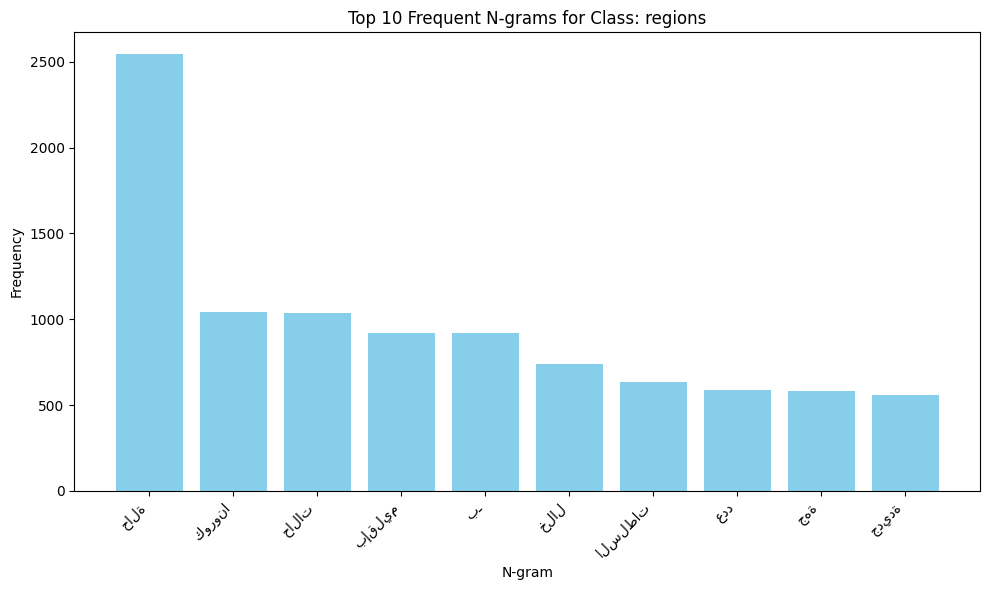

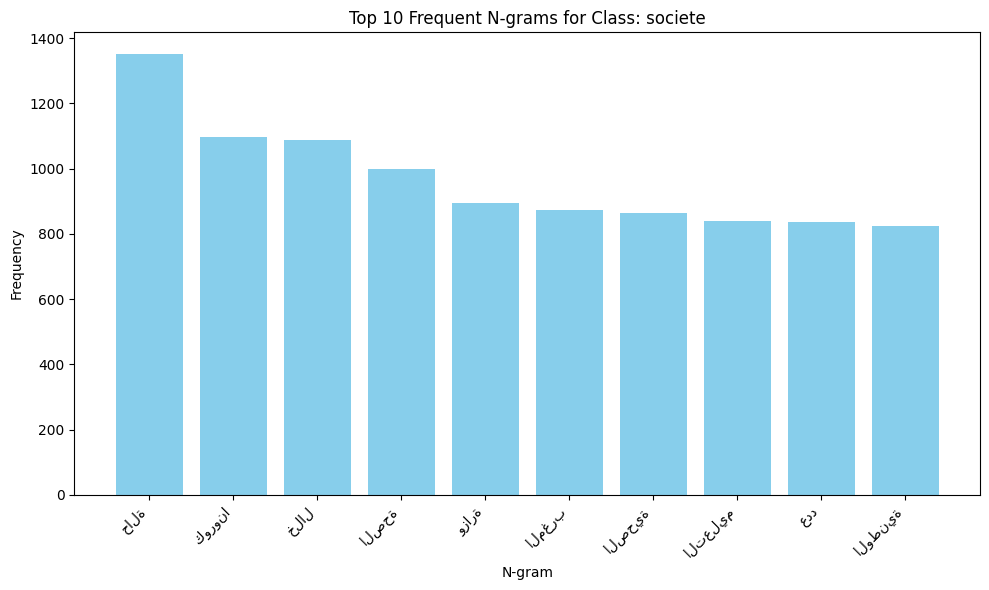

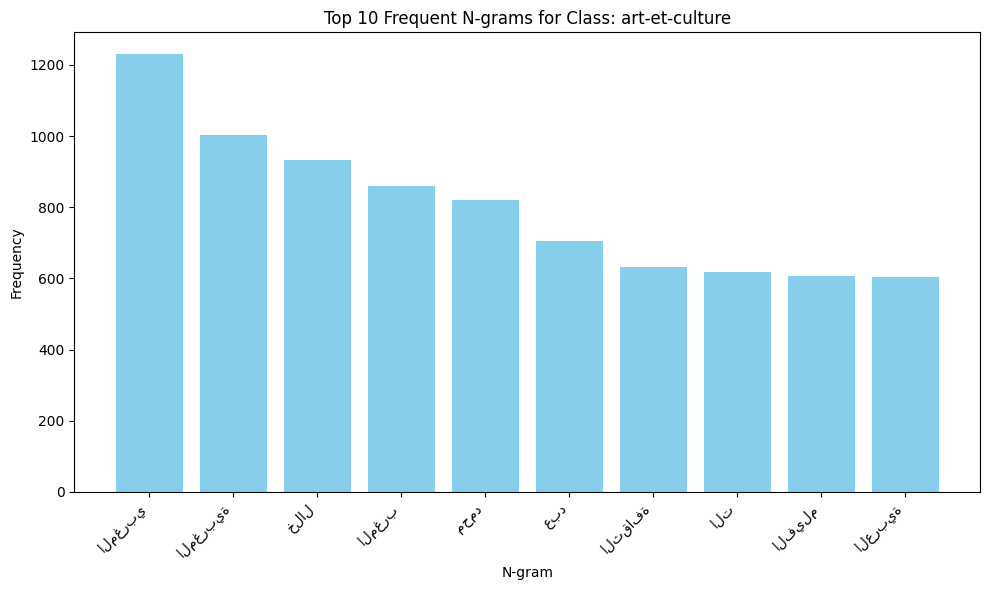

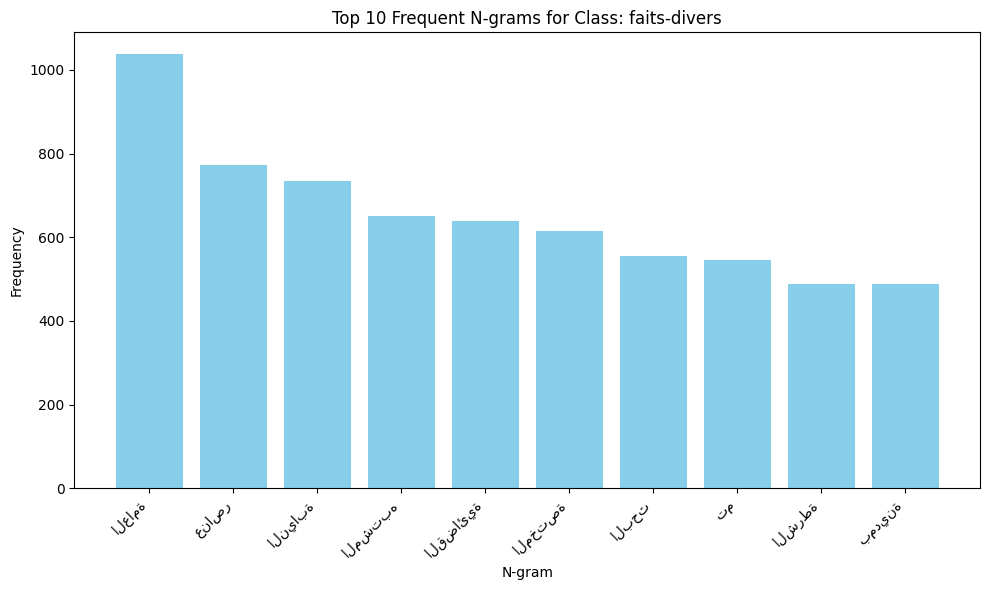

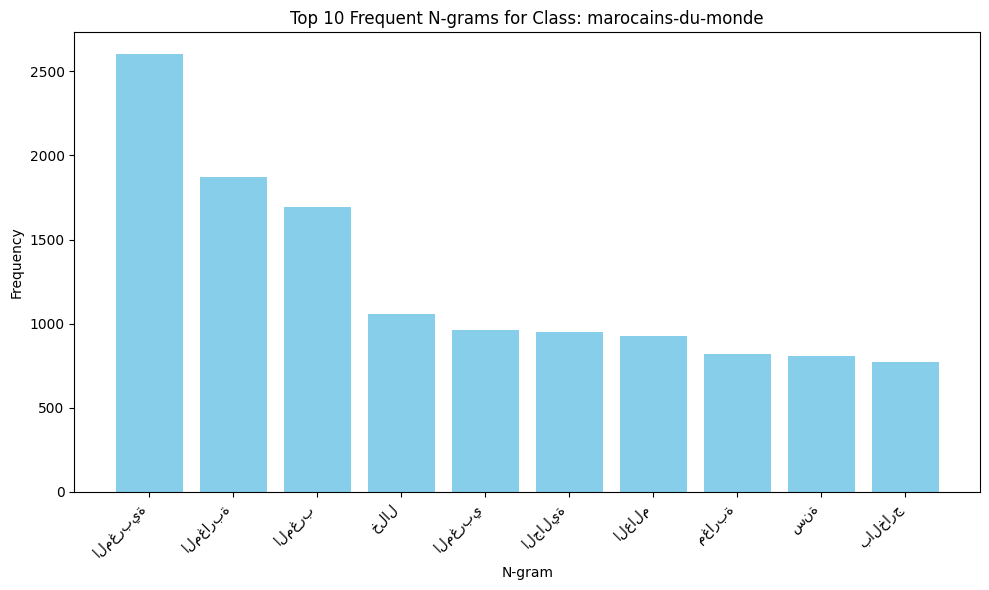

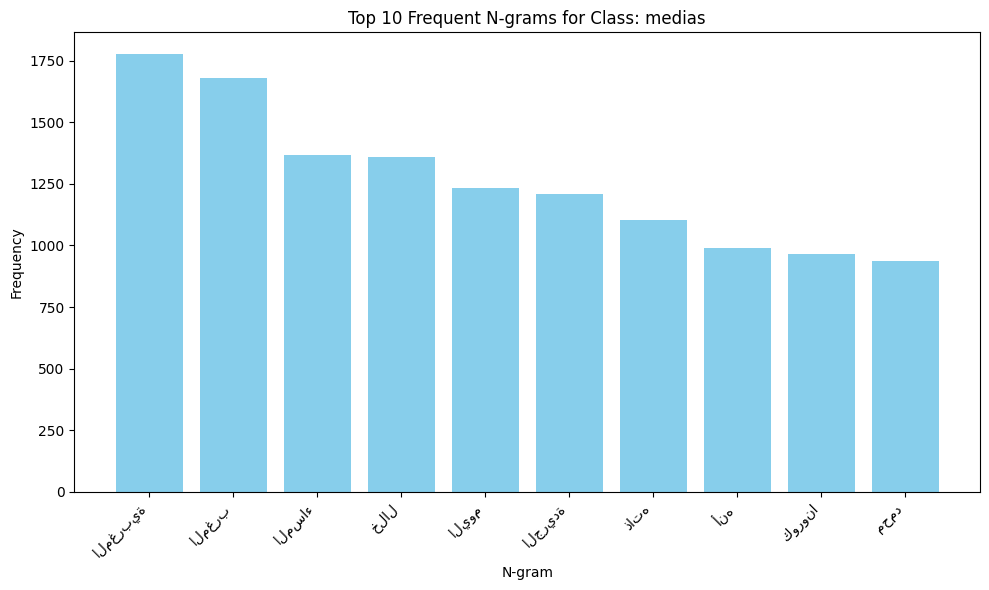

In [45]:
# Create a function to plot the top 10 n-grams for a specific class
def plot_top_ngrams_per_class(class_name, n=10):
    top_ngrams = ngrams_per_class.loc[class_name].sort_values(ascending=False)[:n]
    plt.figure(figsize=(10, 6))
    plt.bar(top_ngrams.index, top_ngrams.values, color='skyblue')
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.title(f'Top {n} Frequent N-grams for Class: {class_name}')
    plt.xticks(rotation=45,  ha='right')
    plt.tight_layout()
    plt.show()

# Assuming you have a list of unique class names in the 'topic' column of ngrams_df_with_class
unique_classes = ngrams_df_with_class['topic'].unique()

# Loop through each class and plot the top 10 frequent n-grams
for class_name in unique_classes:
    plot_top_ngrams_per_class(class_name, n=10)
plt.show()

In [30]:
#Now i don't need the id column as it will not effect on the classfication i just wanted it to understand and clear somethings
df.drop(columns ="id",inplace = True)

In [31]:
df.describe()

,title,story,topic
count,6000,6000,6000
unique,5855,5976,6
top,المغرب يسجل إصابة جديدة مؤكدة بكورونا خلال ساعة,كشفت معطيات وزارة الصحة اليوم الجمعة تسجيل إصا...,regions
freq,55,5,1000


In [32]:
#cobine the title column with the story
df["Story_title"] = df["title"]+df["story"]

In [33]:
df

,title,story,topic,Story_title
0,جهة الدار البيضاء تحصي إصابة بالجائحة يوم,بلغ مؤشر الإصابة بفيروس كورونا آخر ساعة الماضي...,regions,جهة الدار البيضاء تحصي إصابة بالجائحة يومبلغ م...
1,إقليم سيدي إفني يسجل وفاة بسبب كورونا,سجل إقليم سيدي إفني اليوم الجمعة وفاة ناجمة مض...,regions,إقليم سيدي إفني يسجل وفاة بسبب كوروناسجل إقليم...
2,قبور إسمنتية معدة للدفن تثير رفضا بمدينة صفرو,طالب ممثلو فرق المعارضة بمجلس جماعة صفرو المنت...,regions,قبور إسمنتية معدة للدفن تثير رفضا بمدينة صفروط...
3,الفيروس يقتل نائب رئيس بلدية الفقيه بن صالح,توفي النائب الأول لرئيس بلدية الفقيه بنصالح بو...,regions,الفيروس يقتل نائب رئيس بلدية الفقيه بن صالحتوف...
4,شباب ملعب يطلق مبادرات اجتماعية وتنموية,نجح سكان مركز جماعة ملعب الواقعة بالنفوذ الإدا...,regions,شباب ملعب يطلق مبادرات اجتماعية وتنمويةنجح سكا...
...,...,...,...,...
5995,رصيف الصحافة عقوبات تنتظر أمني اختراق الموكب ا...,مستهل قراءة رصيف صحافة بداية الأسبوع اعتراض مو...,medias,رصيف الصحافة عقوبات تنتظر أمني اختراق الموكب ا...
5996,رصيف الصحافة صفحات ساخنة تدو أسرار رجال الحسن ...,قراءة مواد الأسبوعيات الأيام اهتمت بـ أسرار رج...,medias,رصيف الصحافة صفحات ساخنة تدو أسرار رجال الحسن ...
5997,رصيف الصحافة أضخم صفقة عسكرية مغربية قلق الجار...,نستهل جولة رصيف صحافة نهاية الأسبوع استنفار عس...,medias,رصيف الصحافة أضخم صفقة عسكرية مغربية قلق الجار...
5998,رصيف الصحافة مقاتلون مغاربة ينقلبون خليفة داعش...,مستهل قراءة رصيف الصحافة أخبار اليوم قالت مقات...,medias,رصيف الصحافة مقاتلون مغاربة ينقلبون خليفة داعش...


# LabelEncoder
to the target topic

In [34]:
Label_Eencoder = LabelEncoder()
# Fit the LabelEncoder on the target variable to learn the mapping of categories to numerical values
Label_Eencoder.fit(df["topic"])

# Transform the target variable using the LabelEncoder
encoded_target = Label_Eencoder.transform(df["topic"])
encoded_target

array([4, 4, 4, ..., 3, 3, 3])

# Train Test Split

In [35]:
x= df.Story_title.values

In [47]:
# Bag of Words (BoW) Vectorization
count_vectorizer = CountVectorizer()
x= count_vectorizer.fit_transform(x)

In [49]:
x

<6000x132783 sparse matrix of type '<class 'numpy.int64'>'
	with 1327496 stored elements in Compressed Sparse Row format>

In [36]:
y = encoded_target

In [50]:
print(x,y)

  (0, 53996)	12
  (0, 17017)	2
  (0, 13084)	3
  (0, 46861)	1
  (0, 5699)	3
  (0, 34743)	1
  (0, 132715)	1
  (0, 87428)	1
  (0, 10950)	1
  (0, 41556)	1
  (0, 75702)	1
  (0, 49)	1
  (0, 60608)	1
  (0, 24329)	1
  (0, 81070)	1
  (0, 97511)	1
  (0, 48351)	1
  (0, 97413)	2
  (0, 22116)	1
  (0, 36309)	2
  (0, 93549)	1
  (0, 49490)	1
  (0, 48235)	1
  (0, 113111)	1
  (0, 93002)	1
  :	:
  (5999, 127454)	1
  (5999, 73494)	1
  (5999, 4925)	1
  (5999, 57655)	1
  (5999, 116370)	1
  (5999, 53978)	1
  (5999, 85029)	1
  (5999, 23083)	1
  (5999, 8927)	2
  (5999, 40419)	1
  (5999, 64759)	1
  (5999, 57348)	1
  (5999, 52530)	1
  (5999, 73352)	1
  (5999, 64556)	1
  (5999, 8932)	1
  (5999, 7606)	1
  (5999, 15475)	1
  (5999, 68615)	1
  (5999, 65480)	1
  (5999, 64546)	1
  (5999, 71262)	3
  (5999, 19562)	3
  (5999, 34792)	1
  (5999, 86629)	1 [4 4 4 ... 3 3 3]


In [51]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size = .20 ,stratify=y, random_state=1)

In [52]:
print(x_train.shape , x_test.shape ,y_train.shape , y_test.shape)

(4800, 132783) (1200, 132783) (4800,) (1200,)


# Modeling

In [53]:
def train(model, model_name):
    model.fit(x_train, y_train)
    model_train_score = model.score(x_train, y_train)
    model_test_score = model.score(x_test, y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def r2(model, model_name):
    score = r2_score(y_test, model.predict(x_test))
    print(f"R2 Score for {model_name} is {score * 100}%")

In [54]:
def class_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))

In [55]:
def conf_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(12,10))
    heatmap(cm, annot=True, fmt='d');

# LogisticRegression

In [56]:

model = LogisticRegression()
train(model,"LogisticRegression")

LogisticRegression model score on Training data: 100.0%
LogisticRegression model score on Testing data: 89.58333333333334%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
y_pred =model.predict(x_test)
y_pred.shape

(1200,)

In [58]:
y_test.shape

(1200,)

In [59]:
class_report(y_test ,y_pred)

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       200
           1       0.92      0.93      0.92       200
           2       0.91      0.92      0.92       200
           3       0.96      0.88      0.92       200
           4       0.83      0.88      0.86       200
           5       0.85      0.82      0.84       200

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200



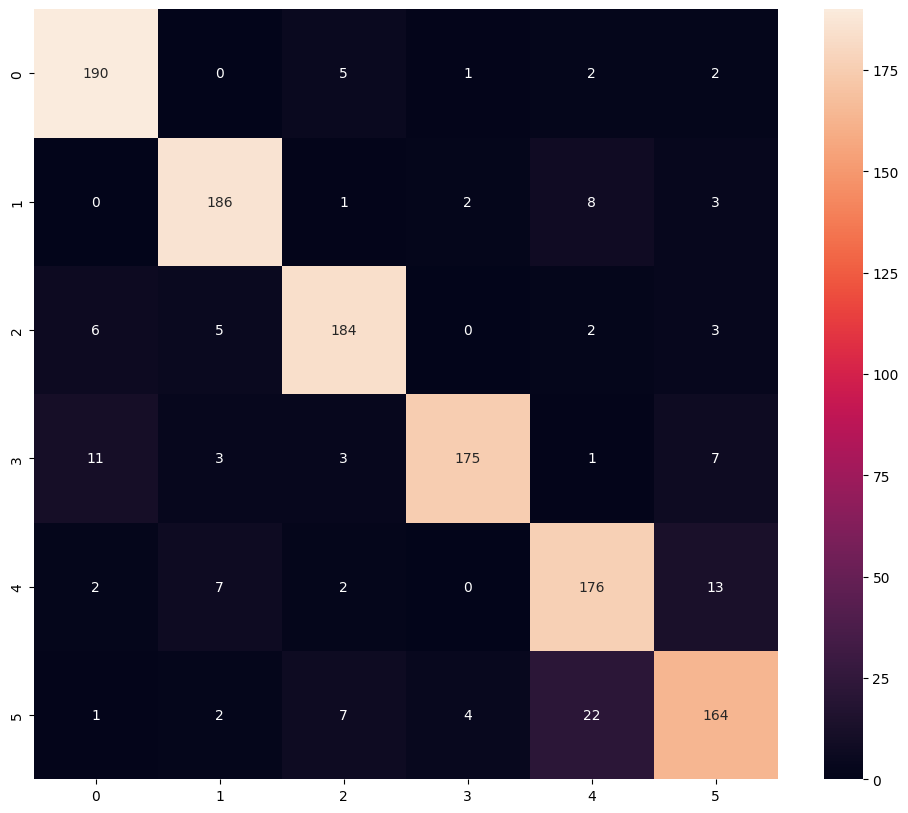

In [60]:
conf_matrix(y_test ,y_pred)

# RandomForestClassifier

In [77]:

model = RandomForestClassifier(n_estimators=100
                              )
train(model,"RandomForestClassifier")

RandomForestClassifier model score on Training data: 100.0%
RandomForestClassifier model score on Testing data: 85.83333333333333%


In [62]:
y_pred =model.predict(x_test)

In [63]:
y_pred =model.predict(x_test)

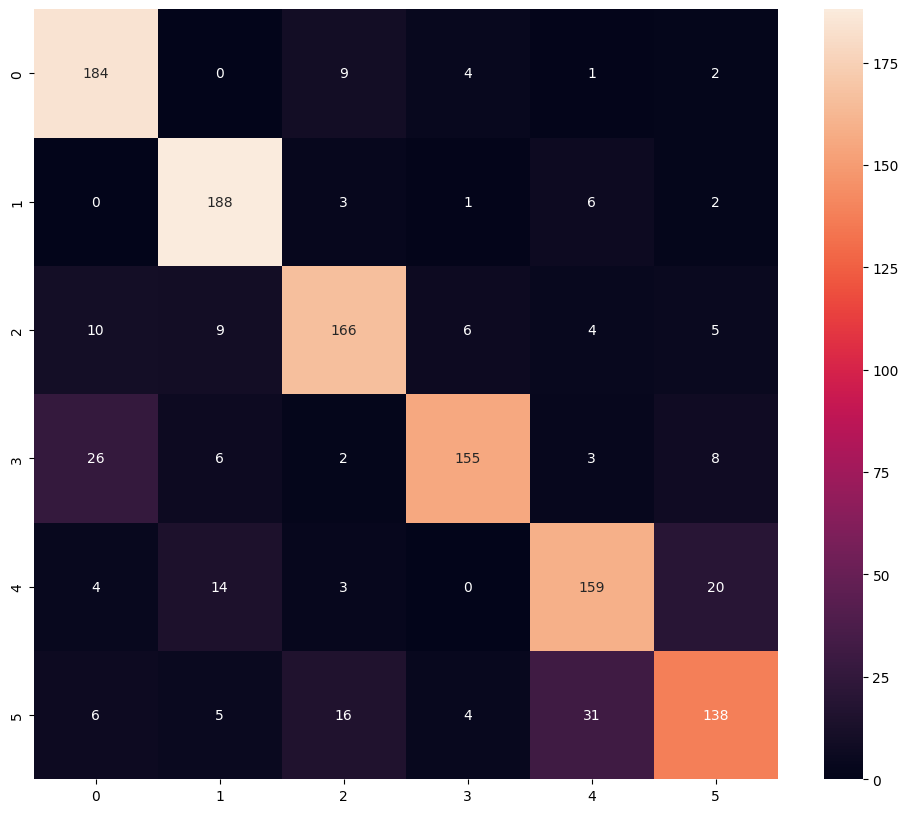

In [64]:
conf_matrix(y_test ,y_pred)

# DecisionTreeClassifier

In [65]:
model = DecisionTreeClassifier()
train(model,"DecisionTreeClassifier")

DecisionTreeClassifier model score on Training data: 100.0%
DecisionTreeClassifier model score on Testing data: 75.33333333333333%


In [66]:
y_pred =model.predict(x_test)

In [67]:
class_report(y_test ,y_pred)

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       200
           1       0.84      0.84      0.84       200
           2       0.75      0.72      0.74       200
           3       0.90      0.74      0.81       200
           4       0.68      0.71      0.70       200
           5       0.62      0.70      0.66       200

    accuracy                           0.75      1200
   macro avg       0.76      0.75      0.76      1200
weighted avg       0.76      0.75      0.76      1200



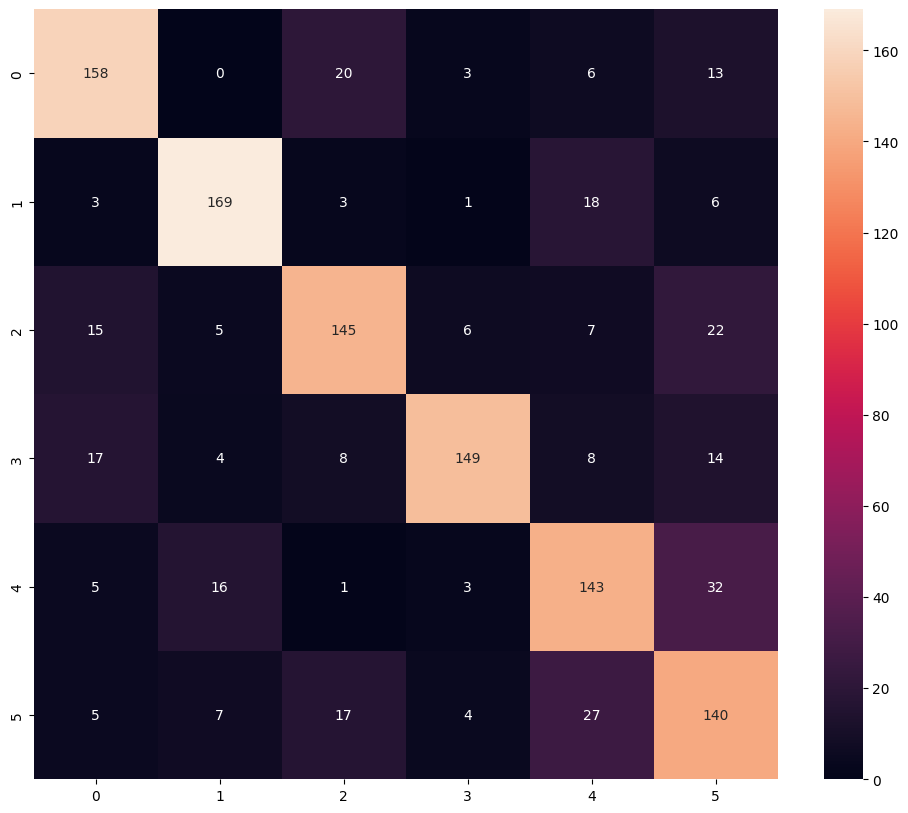

In [68]:
conf_matrix(y_test ,y_pred)